In [305]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import HTML
from pybounds import Simulator

In [306]:
from double_pendulum import DoublePendulumParameters, DoublePendulumModel, DoublePendulumDrawer
# Now import the dual antenna class
from double_pendulum import DualAntennaPendulumDrawer
from double_pendulum import DualAntennaModel, DualAntennaParameters

In [307]:
dt = 0.05  #  time-step [s]

In [308]:
params = DualAntennaParameters(
    # Left antenna (first antenna) - default parameters
    g=0.0,  # gravity
    L_1_l=1.0, L_2_l=1.0,  # length
    k_1_l=10.0, k_2_l=10.0,  # torsional stiffness
    c_1_l=1.0, c_2_l=1.0,  # torsional damping
    m_1_l=1.0, m_2_l=1.0,  # mass
    c_w_1_l=1.0, c_w_2_l=1.0,  # wind damping
    J_1_l=None, J_2_l=None,  # inertia automatically computed
    
    # Right antenna (second antenna) - your custom parameters
    #g = 0.0,  # gravity (this is global, will be overridden)
    L_1_r=1.0, L_2_r=1.0,  # length
    k_1_r=10.0, k_2_r=10.0,  # torsional stiffness (k_1=0, k_2=1)
    c_1_r=1.0, c_2_r=1.0,  # torsional damping
    m_1_r=1.0, m_2_r=1.0,  # mass
    c_w_1_r=0.0, c_w_2_r=0.0,  # wind damping (set to 0)
    J_1_r=None, J_2_r=None,  # inertia automatically computed
)

In [309]:
model = DualAntennaModel(parameters=params)

In [310]:
simulator = Simulator(model.f, model.h,
                      dt=dt,
                      state_names=model.state_names,
                      input_names=model.input_names,
                      measurement_names=model.measurement_names)

In [311]:
T = 5.0  # total time [s]
tsim = np.arange(start=0.0, stop=T + 1e-3, step=dt)  # time vector [s]

NA = np.zeros_like(tsim)


In [312]:
model = DualAntennaModel(parameters=params)

    # Define setpoints for dual antenna system
setpoint = {
    'x_l': 1.0 * np.sin(2*np.pi*(1/T)*tsim),
    'y_l': 1.0 * np.cos(2*np.pi*(1/T)*tsim),
    'x_r': 1.0 * np.sin(2*np.pi*(1/T)*tsim),
    'y_r': 1.0 * np.cos(2*np.pi*(1/T)*tsim),
    
    # Make the second segments follow the first segments more naturally
    'theta_1_l': (np.pi/16) * np.sin(2*np.pi*(3/T)*tsim),      
    'theta_2_l': 0.0 * np.ones_like(tsim),  # Smaller oscillation, slight delay
    
    'theta_1_r': (np.pi/16) * np.sin(2*np.pi*(3/T)*tsim), 
    'theta_2_r':  0.0 * np.ones_like(tsim), # Smaller oscillation, slight delay
    
    'x_dot_l': NA, 'y_dot_l': NA, 'theta_dot_1_l': NA, 'theta_dot_2_l': NA,
    'x_dot_r': NA, 'y_dot_r': NA, 'theta_dot_1_r': NA, 'theta_dot_2_r': NA,
    'w_l': 1.0 * np.ones_like(tsim), 'zeta_l': (-np.pi/2) * np.ones_like(tsim),
    'w_r': 1.0 * np.ones_like(tsim), 'zeta_r': (-np.pi/2) * np.ones_like(tsim),
}
    # Update simulator with setpoints
simulator.update_dict(setpoint, name='setpoint')

In [313]:
params = DualAntennaParameters(
    g=0.0,
    # Right antenna gets your custom parameters
    k_1_r=0.0, k_2_r=1.0, c_w_1_r=0.0, c_w_2_r=0.0,
    # Left antenna gets default parameters
    k_1_l=1.0, k_2_l=1.0, c_w_1_l=1.0, c_w_2_l=1.0,
)
model = DualAntennaModel(parameters=params, primary_antenna='right')  # Choose which antenna your cost function controls

In [314]:
# CORRECTED: Use the actual available setpoint names

# Control both antennae with same patterns (coordinated movement)
cost_both_same = ((simulator.model.x['x_l'] - simulator.model.tvp['x_l_set']) ** 2 +
                  (simulator.model.x['y_l'] - simulator.model.tvp['y_l_set']) ** 2 +
                  (simulator.model.x['theta_1_l'] - simulator.model.tvp['theta_1_l_set']) ** 2 +
                  (simulator.model.x['x_r'] - simulator.model.tvp['x_r_set']) ** 2 +
                  (simulator.model.x['y_r'] - simulator.model.tvp['y_r_set']) ** 2 +
                  (simulator.model.x['theta_1_r'] - simulator.model.tvp['theta_1_r_set']) ** 2)

# Control only the right antenna (your custom parameters)
cost_right_only = ((simulator.model.x['x_r'] - simulator.model.tvp['x_r_set']) ** 2 +
                   (simulator.model.x['y_r'] - simulator.model.tvp['y_r_set']) ** 2 +
                   (simulator.model.x['theta_1_r'] - simulator.model.tvp['theta_1_r_set']) ** 2)

# Control only the left antenna
cost_left_only = ((simulator.model.x['x_l'] - simulator.model.tvp['x_l_set']) ** 2 +
                  (simulator.model.x['y_l'] - simulator.model.tvp['y_l_set']) ** 2 +
                  (simulator.model.x['theta_1_l'] - simulator.model.tvp['theta_1_l_set']) ** 2)

# Choose one:
cost = cost_both_same # Recommended since right antenna has your custom parameters

In [315]:
# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)

In [316]:
simulator.mpc.set_rterm(
    # Left antenna - discourage movement (high penalties)
    x_ddot_l=1e-3, y_ddot_l=1e-3, tau_1_l=1e-3, tau_2_l=1e-3,
    
    # Right antenna - your original regularization values
    x_ddot_r=1e-6, y_ddot_r=1e-6, tau_1_r=1e-6, tau_2_r=1e-12
)

In [317]:
t_sim, x_sim, u_sim, y_sim = simulator.simulate(mpc=True, return_full_output=True)


In [318]:
sim_data_full = pd.DataFrame(y_sim, columns=model.measurement_names)
sim_data_full.insert(0, 'time', t_sim)
sim_data_full

,time,theta_1_l,theta_2_l,theta_dot_1_l,theta_dot_2_l,x_l,y_l,x_dot_l,y_dot_l,w_l,...,x_ddot_l,y_ddot_l,tau_1_l,tau_2_l,x_ddot_r,y_ddot_r,tau_1_r,tau_2_r,theta_2_1_l,theta_2_1_r
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,...,4.799043,-0.995274,8.353366,-0.792524,27.517897,-1.493740,15.271870,-25.227709,0.000000,0.000000
1,0.05,0.001065,-0.014490,0.015565,-0.521484,0.005999,0.998756,0.239952,-0.049764,1.0,...,6.830443,-1.545962,14.380609,-2.334595,6.337279,-1.696792,24.148968,-8.083677,-0.015555,-0.224128
2,0.10,0.010456,-0.071492,0.279142,-1.586628,0.026534,0.994335,0.581474,-0.127062,1.0,...,6.912490,-1.755708,18.376285,-4.208030,-5.991181,-1.568092,28.757275,-20.196689,-0.081948,-0.567000
3,0.15,0.033404,-0.180822,0.528756,-2.554934,0.064249,0.985788,0.927099,-0.214847,1.0,...,5.786111,-1.746894,20.682538,-6.147991,-4.515947,-1.495946,30.631555,-4.841265,-0.214226,-0.914173
4,0.20,0.064555,-0.327070,0.614587,-3.079834,0.117836,0.972862,1.216404,-0.302192,1.0,...,4.077570,-1.648420,21.664363,-8.018385,-0.587583,-1.502950,31.139627,-49.786100,-0.391625,-1.209519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,4.80,-0.136927,-1.343112,0.480239,-0.541769,-0.252903,0.966488,1.135700,0.301791,1.0,...,-1.045794,-1.404031,19.166768,-15.273442,1.315755,-1.592064,24.377260,-15.242335,-1.206185,-1.464452
97,4.85,-0.111503,-1.375744,0.526042,-0.733609,-0.197425,0.979822,1.083410,0.231589,1.0,...,-1.759123,-1.253982,18.294554,-16.045157,0.823797,-1.673665,20.481926,-8.792661,-1.264241,-1.420736
98,4.90,-0.084816,-1.416750,0.532119,-0.879373,-0.145453,0.989834,0.995454,0.168890,1.0,...,-2.414057,-1.075460,17.434413,-16.500004,-2.474333,-1.485612,10.556983,-138.387082,-1.331934,-1.361550
99,4.95,-0.058833,-1.463164,0.500343,-0.955165,-0.098698,0.996934,0.874751,0.115117,1.0,...,-2.902903,-0.886843,16.715012,-16.657544,-10.609128,-1.127532,3.972142,179.932833,-1.404331,-1.732795


In [319]:
plt.rcParams['animation.embed_limit'] = 100

In [320]:
drawer_individual_bases = DualAntennaPendulumDrawer(
    # Use left antenna base position as the reference
    base_x=sim_data_full['x_l'].values,
    base_y=sim_data_full['y_l'].values,
    
    theta1_left=sim_data_full['theta_1_l'].values,
    theta2_left=sim_data_full['theta_2_l'].values,
    theta1_right=sim_data_full['theta_1_r'].values,
    theta2_right=sim_data_full['theta_2_r'].values,
    
    L1_left=model.parameters.L_1_l, L2_left=model.parameters.L_2_l,
    L1_right=model.parameters.L_1_r, L2_right=model.parameters.L_2_r,
    
    left_seg1_kwargs=dict(color='darkblue', linewidth=4.0, markersize=8),
    left_seg2_kwargs=dict(color='blue', linewidth=3.0, markersize=6),
    right_seg1_kwargs=dict(color='darkred', linewidth=4.0, markersize=8),
    right_seg2_kwargs=dict(color='red', linewidth=3.0, markersize=6),
    
    trail1_left=True, trail2_left=True,
    trail1_right=True, trail2_right=True,
    trail_base=True,
    
    antenna_separation=0.3,
    body_style='dot'
)

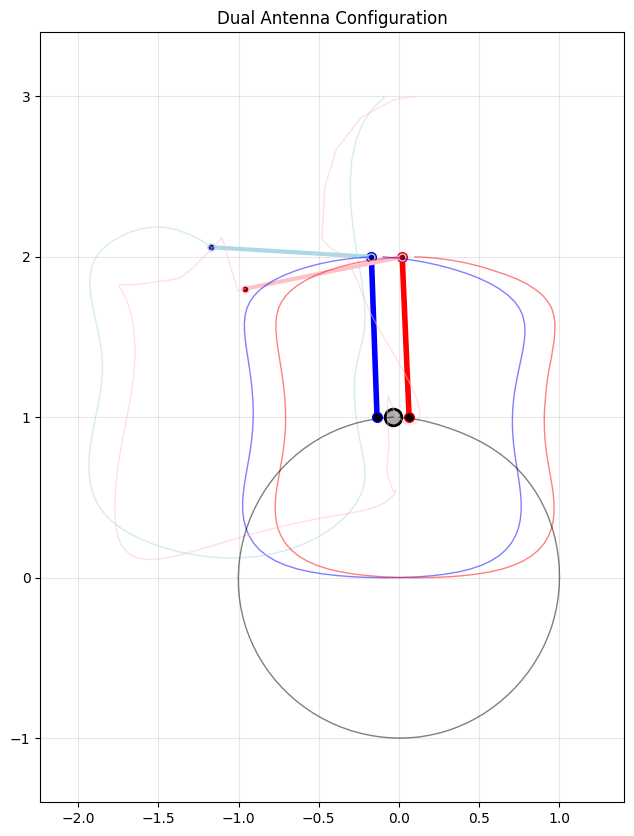

In [321]:
# 1. Prepare your data arrays using the correct column names
base_x = (sim_data_full['x_l'].values + sim_data_full['x_r'].values) / 2  # Average base position
base_y = (sim_data_full['y_l'].values + sim_data_full['y_r'].values) / 2  # Average base position

# Left antenna data
theta1_left = sim_data_full['theta_1_l'].values   # Left antenna first segment
theta2_left = sim_data_full['theta_2_l'].values   # Left antenna second segment

# Right antenna data  
theta1_right = sim_data_full['theta_1_r'].values  # Right antenna first segment
theta2_right = sim_data_full['theta_2_r'].values  # Right antenna second segment

# 2. Create the drawer
drawer = DualAntennaPendulumDrawer(
    base_x, base_y,
    theta1_left, theta2_left, theta1_right, theta2_right,
    
    # Optional: Add antenna lengths and styling
    L1_left=model.parameters.L_1_l, L2_left=model.parameters.L_2_l,
    L1_right=model.parameters.L_1_r, L2_right=model.parameters.L_2_r,
    
    left_seg1_kwargs=dict(color='blue', linewidth=4.0, markersize=7),
    left_seg2_kwargs=dict(color='lightblue', linewidth=3.0, markersize=5),
    right_seg1_kwargs=dict(color='red', linewidth=4.0, markersize=7),
    right_seg2_kwargs=dict(color='pink', linewidth=3.0, markersize=5),
    
    trail1_left=True, trail2_left=True,
    trail1_right=True, trail2_right=True,
    trail_base=True,
    
    antenna_separation=0.2,
    body_style='dot'
)

# 3. Draw it
fig, ax = plt.subplots(figsize=(10, 10))
drawer.draw(ax, frame=-1)  # Draw last frame
bounds = drawer.get_axis_bounds(margin=0.1)
ax.set_xlim(bounds[0], bounds[1])
ax.set_ylim(bounds[2], bounds[3])
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_title('Dual Antenna Configuration')
plt.show()

In [322]:
# Make figure
fig, ax = plt.subplots(nrows=1, ncols=1)

def update(frame):
    ax.clear()
    drawer.draw(ax, frame=frame)
    ax.set_aspect('equal')
    ax.axis(drawer.get_axis_bounds())

# Make animation
animation = mpl.animation.FuncAnimation(
    fig, update,
    frames=sim_data_full.shape[0],
    blit=False,
    interval=int(1000 * dt))

# update(0)
plt.close(fig)

In [323]:
# Display it
HTML(animation.to_jshtml())